### Library Imports 

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import pymc as pm
import pymc.sampling_jax
import matplotlib.pyplot as plt
import arviz as az
import pickle
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc

from warnings import filterwarnings
filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)


%matplotlib inline

### Defining functions

In [2]:
def plot_mean_roc(y_true, posterior_samples, title='Mean ROC curve with 95% CI'):
    fpr_grid = np.linspace(0, 1, 64)
    tpr_interpolated = []
    aucs = []
    
    
    for i in range(posterior_samples.shape[1]):
        y_scores = posterior_samples[i]
        fpr, tpr, _ = roc_curve(y, y_scores)
        tpr_interpolated.append(np.interp(fpr_grid, fpr, tpr))
        aucs.append(auc(fpr, tpr))
    
    # Convertir en array numpy pour faciliter les calculs
    tpr_interpolated = np.array(tpr_interpolated)
    
    # Calculer la TPR moyenne et son intervalle de confiance à 95%
    mean_tpr = tpr_interpolated.mean(axis=0)
    std_tpr = tpr_interpolated.std(axis=0)
    ci_lower = np.percentile(tpr_interpolated, 2.5, axis=0)
    ci_upper = np.percentile(tpr_interpolated, 97.5, axis=0)
    
    # Calculer la moyenne des AUC
    mean_auc = np.mean(aucs)
    lower_auc = np.percentile(aucs, 2.5)
    upper_auc = np.percentile(aucs, 97.5)

    # Create the title with the mean AUC and 95% CI
    title = f'Mean ROC curve with 95% CI (AUC = {mean_auc:.2f}, 95% CI: {lower_auc:.2f} - {upper_auc:.2f})'

    
    # Tracer la courbe ROC moyenne avec les intervalles de confiance
    plt.plot(fpr_grid, mean_tpr, color='blue', label='Mean ROC')
    plt.fill_between(fpr_grid, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

In [3]:
def calculate_mean_f1(y_true, posterior_samples, threshold=0.5):
    """
    Calcule et affiche la moyenne des F1 scores à partir des échantillons postérieurs.
    
    :param y_true: np.array, vecteur de labels binaires de taille (n_samples,)
    :param posterior_samples: np.array, matrice de taille (n_samples, n_estimations)
    :param threshold: float, seuil pour convertir les scores en labels binaires
    :return: float, moyenne des F1 scores
    """
    f1_scores = []

    for i in range(posterior_samples.shape[1]):
        y_scores = posterior_samples[i]
        y_pred = (y_scores >= threshold).astype(int)
        f1_scores.append(f1_score(y_true, y_pred))

    mean_f1 = np.mean(f1_scores)
    print(f'Mean F1 Score: {mean_f1:.2f}')
    return mean_f1

In [4]:
def calculate_mean_confusion_matrix(y_true, posterior_samples, threshold=0.5): 
    """
    Calcule et affiche la moyenne des matrices de confusion à partir des échantillons postérieurs.
    
    :param y_true: np.array, vecteur de labels binaires de taille (n_samples,) 
    :param posterior_samples: np.array, matrice de taille (n_samples, n_estimations)
    :param threshold: float, seuil pour convertir les scores en labels binaires
    :return: np.array, matrice de confusion moyenne 
    """

    
    confusion_matrices = [] 

    for i in range(posterior_samples.shape[1]): 
        y_scores = posterior_samples[i] 
        y_pred = (y_scores >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        confusion_matrices.append(cm) 

    mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
    print(f'Mean Confusion Matrix:\n{mean_confusion_matrix}')
    return mean_confusion_matrix

In [5]:
def calculate_information_criteria(trace, model, y):
    """
    Calculate AIC, BIC, and WAIC for a PyMC model using arviz.InferenceData.
    
    Parameters:
    trace (arviz.InferenceData): Posterior samples from the model.
    model (pymc.Model): The PyMC model object.
    y (array-like): Observed data.
    
    Returns:
    dict: A dictionary containing AIC, BIC, and WAIC values.
    """
    
    # Check if log_likelihood already exists in trace
    if 'log_likelihood' not in trace.groups():
        # Compute log-likelihood if not already computed
        pm.compute_log_likelihood(trace, model=model)
    
    # Extract log-likelihood
    log_likelihood = trace.log_likelihood['y_obs'].values
    
    # Check for and remove any infinite values
    finite_log_likelihood = log_likelihood[np.isfinite(log_likelihood)]
    
    if len(finite_log_likelihood) == 0:
        logging.error("All log-likelihood values are non-finite.")
        return {'AIC': np.nan, 'BIC': np.nan, 'WAIC': np.nan}
    
    if len(finite_log_likelihood) < len(log_likelihood):
        logging.warning(f"Removed {len(log_likelihood) - len(finite_log_likelihood)} non-finite log-likelihood values.")
    
    parameter_names = [var for var in trace.posterior.data_vars if not var.endswith('_') and var != 'p_i']
    
    # Number of parameters
    k = len(parameter_names)
    
    # Number of data points
    n = len(y)
    
    # Compute mean log-likelihood
    mean_log_likelihood = np.mean(finite_log_likelihood)
    
    # Compute AIC
    aic = 2 * k - 2 * mean_log_likelihood
    
    # Compute BIC
    bic = k * np.log(n) - 2 * mean_log_likelihood
    
    # Compute WAIC
    try:
        waic = az.waic(trace)
        waic_value = waic
    except Exception as e:
        logging.error(f"Error computing WAIC: {str(e)}")
        waic_value = np.nan
        
    return {
        'AIC': aic,
        'BIC': bic,
        'WAIC': waic_value
    }

### Dataset

In [6]:
# Read in data and display first 5 lines
data = pd.read_csv("/mnt/d/Last_attempt/proximity_data.csv")
data.head()

experiment  duration  seeder  Cap2  time_between_0.05_and_0.5m  \
0           1         1     436   100                    2.783333   
1           1         1     436   116                    4.500000   
2           1         1     436   255                    6.200000   
3           1         1     436   449                   17.016667   
4           1         1     436  3008                    0.183333   

   time_between_0.5_and_1m  time_between_1_and_2m  time_above_2m  infected  
0                10.600000              23.483333      25.850000         0  
1                20.983333              23.216667      13.916667         0  
2                20.900000              27.200000       8.416667         0  
3                20.733333              15.933333       9.050000         0  
4                 1.033333               9.700000      51.816667         0

In [7]:
y = data["infected"].to_numpy()
t0 = data['time_between_0.05_and_0.5m'].to_numpy()
t1 = data['time_between_0.5_and_1m'].to_numpy()
t2 = data['time_between_1_and_2m'].to_numpy()
t3 = data['time_above_2m'].to_numpy()

### Models

1. model 1:

$$p_i = 1 - (1-p)^{t_0} \cdot (1-\alpha_{1} p)^{t_1} \cdot (1-\alpha_{2} p)^{t_2} \cdot (1-\alpha_{3} p)^{t_3} \qquad where \qquad \alpha_3 < \alpha_2 < \alpha_1, \quad \alpha_1 < 1$$

2. model 2:

$$p_i = 1 - (1-p)^{t_0} \cdot (1-\alpha_{1} p)^{t_1}  \qquad where \qquad \alpha_2 < \alpha_1, \quad \alpha_1 < 1$$

3. model 3:

$$p_i = 1 - (1-\alpha_{2} p)^{t_2} \cdot (1-\alpha_{3} p)^{t_3} \qquad where \qquad \alpha_3 < \alpha_2  \quad \alpha_2 < 1$$

4. model 4:

$$p_i = 1 - (1-\alpha_{1} p)^{t_1} \cdot (1-\alpha_{2} p)^{t_2} \cdot (1-\alpha_{3} p)^{t_3} \qquad where \qquad \alpha_3 < \alpha_2 < \alpha_1, \quad \alpha_1 < 1$$


### Sampling

In [8]:
with pm.Model() as model1:
    # Priors
    p = pm.Beta('p', 1, 1)
    

    # alpha_1 = pm.TruncatedNormal('alpha_1', mu=0.5, sigma=0.1, lower=0.057, upper=1)
    # alpha_2 = pm.Normal('alpha_2', mu=0.25, sigma=0.1)
    # alpha_3 = pm.Normal('alpha_3', mu=0.125, sigma=0.05)

    alpha_1 = pm.Uniform('alpha_1', 0, 1)
    alpha_2 = pm.Uniform('alpha_2', 0, 1)
    alpha_3 = pm.Uniform('alpha_3', 0, 1)


    p_i = 1 - (1 - p)**t0 * (1 - alpha_1 * p)**t1 * (1 - alpha_1* alpha_2 * p)**t2 * (1 - alpha_1 * alpha_2* alpha_3 * p)**t3


    alpha_12 = pm.Deterministic('alpha_12', alpha_1* alpha_2)

    alpha_123 = pm.Deterministic('alpha_123',alpha_1 * alpha_2* alpha_3)

    
    p_i = pm.Deterministic('p_i', p_i)

    # Ind = pm.Deterministic('Ind', int((alpha_1 > alpha_2) and (alpha_2 > alpha_3)))

    # Likelihood
    y_true = pm.Bernoulli('y_obs', p=p_i, observed=y)


    init = {'p': 0.001}

with model1:
    trace1 = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.96, initvals=init)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [9]:
%%time
with pm.Model() as model2:
    # Priors
    p = pm.Beta('p', 1, 1)
    alpha_1 = pm.Uniform('alpha_1', 0, 1)    
    
    p_i = 1 - (1 - p)**t0 * (1 - alpha_1 * p)**t1 
    p_i = pm.Deterministic('p_i', p_i)

    # Likelihood
    y_true = pm.Bernoulli('y_obs', p=p_i, observed=y)

    init = {'p': 0.001}

with model2:
    trace2 = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95, initvals=init)

CPU times: user 13.2 s, sys: 100 ms, total: 13.3 s
Wall time: 6.63 s


In [10]:
with pm.Model() as model3:
    # Priors
    p = pm.Beta('p', 1, 1)
    # alpha_2 = pm.Uniform('alpha_2', 0, 1)
    alpha_3 = pm.Uniform('alpha_3', 0, 1)    
    p_i = 1 - (1 - p)**t2 * (1 - alpha_3*p)**t3
    p_i = pm.Deterministic('p_i', p_i)

    # Likelihood
    y_true = pm.Bernoulli('y_obs', p=p_i, observed=y)

    init = {'p': 0.001}

with model3:
    trace3 = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95, initvals=init)

In [11]:
%%time
with pm.Model() as model4:
    # Priors

    p = pm.Beta('p', 1, 1)
    alpha_2 = pm.Uniform('alpha_2', 0, 1) 
    alpha_3 = pm.Uniform('alpha_3', 0, 1) 

    p_i = 1 - (1 - p)**t1 * (1 - alpha_2 * p)**t2 * (1 - alpha_3 * p)**t3

    
    p_i = pm.Deterministic('p_i', p_i)

    # Likelihood
    y_true = pm.Bernoulli('y_obs', p=p_i, observed=y)

    init = {'p': 0.001}

with model4:
    trace4 = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95, initvals=init)

CPU times: user 24.8 s, sys: 79.5 ms, total: 24.9 s
Wall time: 8.94 s


In [12]:
samples1 = trace1.posterior.stack(sample=("chain", "draw"))
samples2 = trace2.posterior.stack(sample=("chain", "draw"))
samples3 = trace3.posterior.stack(sample=("chain", "draw"))
samples4 = trace4.posterior.stack(sample=("chain", "draw"))

In [13]:
p_ind1 = pd.DataFrame(samples1['p_i'].values)
p_ind2 = pd.DataFrame(samples2['p_i'].values)
p_ind3 = pd.DataFrame(samples3['p_i'].values)
p_ind4 = pd.DataFrame(samples4['p_i'].values)

### Posterior plots

In [14]:
az.summary(trace1, hdi_prob=.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha_1    0.446  0.269     0.041      0.939      0.001    0.001   44477.0   
alpha_12   0.257  0.194     0.011      0.665      0.001    0.001   46020.0   
alpha_123  0.161  0.138     0.005      0.453      0.001    0.000   47583.0   
alpha_2    0.598  0.241     0.194      1.000      0.001    0.001   56979.0   
alpha_3    0.653  0.233     0.232      1.000      0.001    0.001   63146.0   
...          ...    ...       ...        ...        ...      ...       ...   
p_i[59]    0.125  0.029     0.071      0.183      0.000    0.000   92468.0   
p_i[60]    0.103  0.026     0.056      0.155      0.000    0.000  101574.0   
p_i[61]    0.147  0.039     0.077      0.224      0.000    0.000   72114.0   
p_i[62]    0.215  0.074     0.092      0.366      0.000    0.000   61910.0   
p_i[63]    0.138  0.034     0.075      0.206      0.000    0.000   84581.0   

           ess_tail  r_hat  
alpha_1     43238.0    1.0  
alpha_12    52214.0    1.0  
alpha_123   55858.0    1.0  
alpha_2     39421.0    1.0  
alpha_3     42372.0    1.0  
...             ...    ...  
p_i[59]     72512.0    1.0  
p_i[60]     73283.0    1.0  
p_i[61]     72728.0    1.0  
p_i[62]     68765.0    1.0  
p_i[63]     73985.0    1.0  

[70 rows x 9 columns]

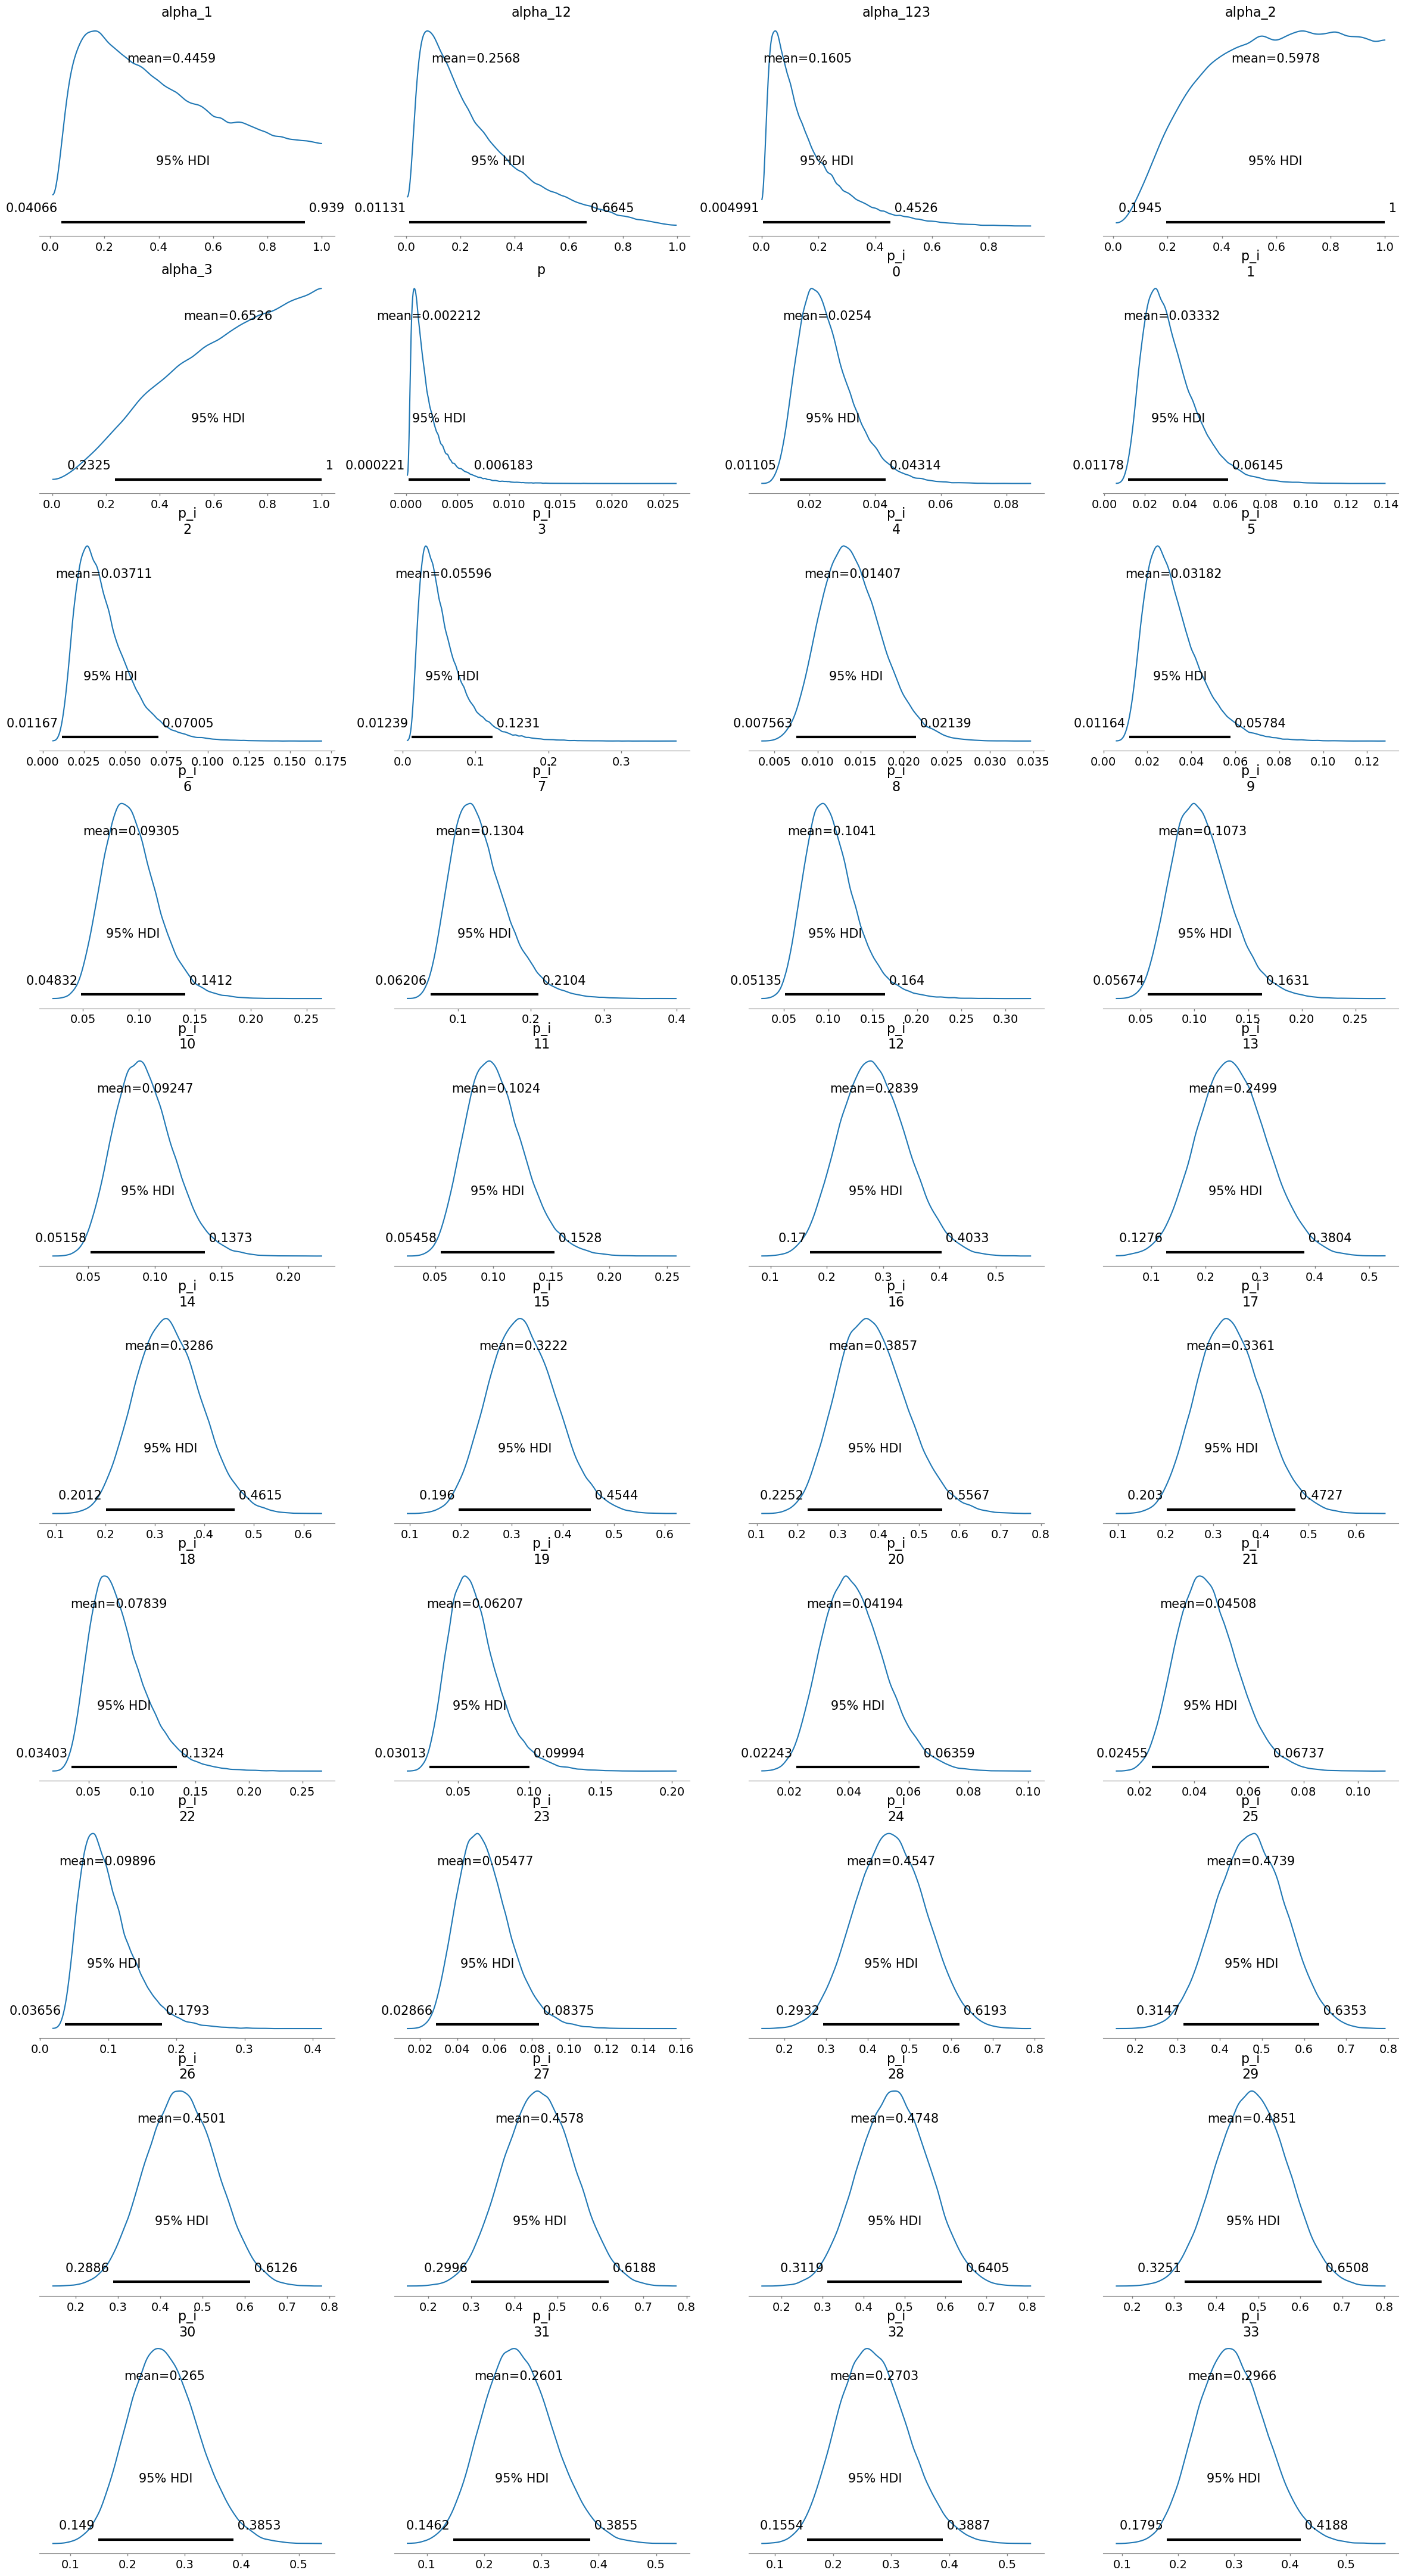

In [15]:
az.plot_posterior(trace1, round_to=4, hdi_prob=.95);

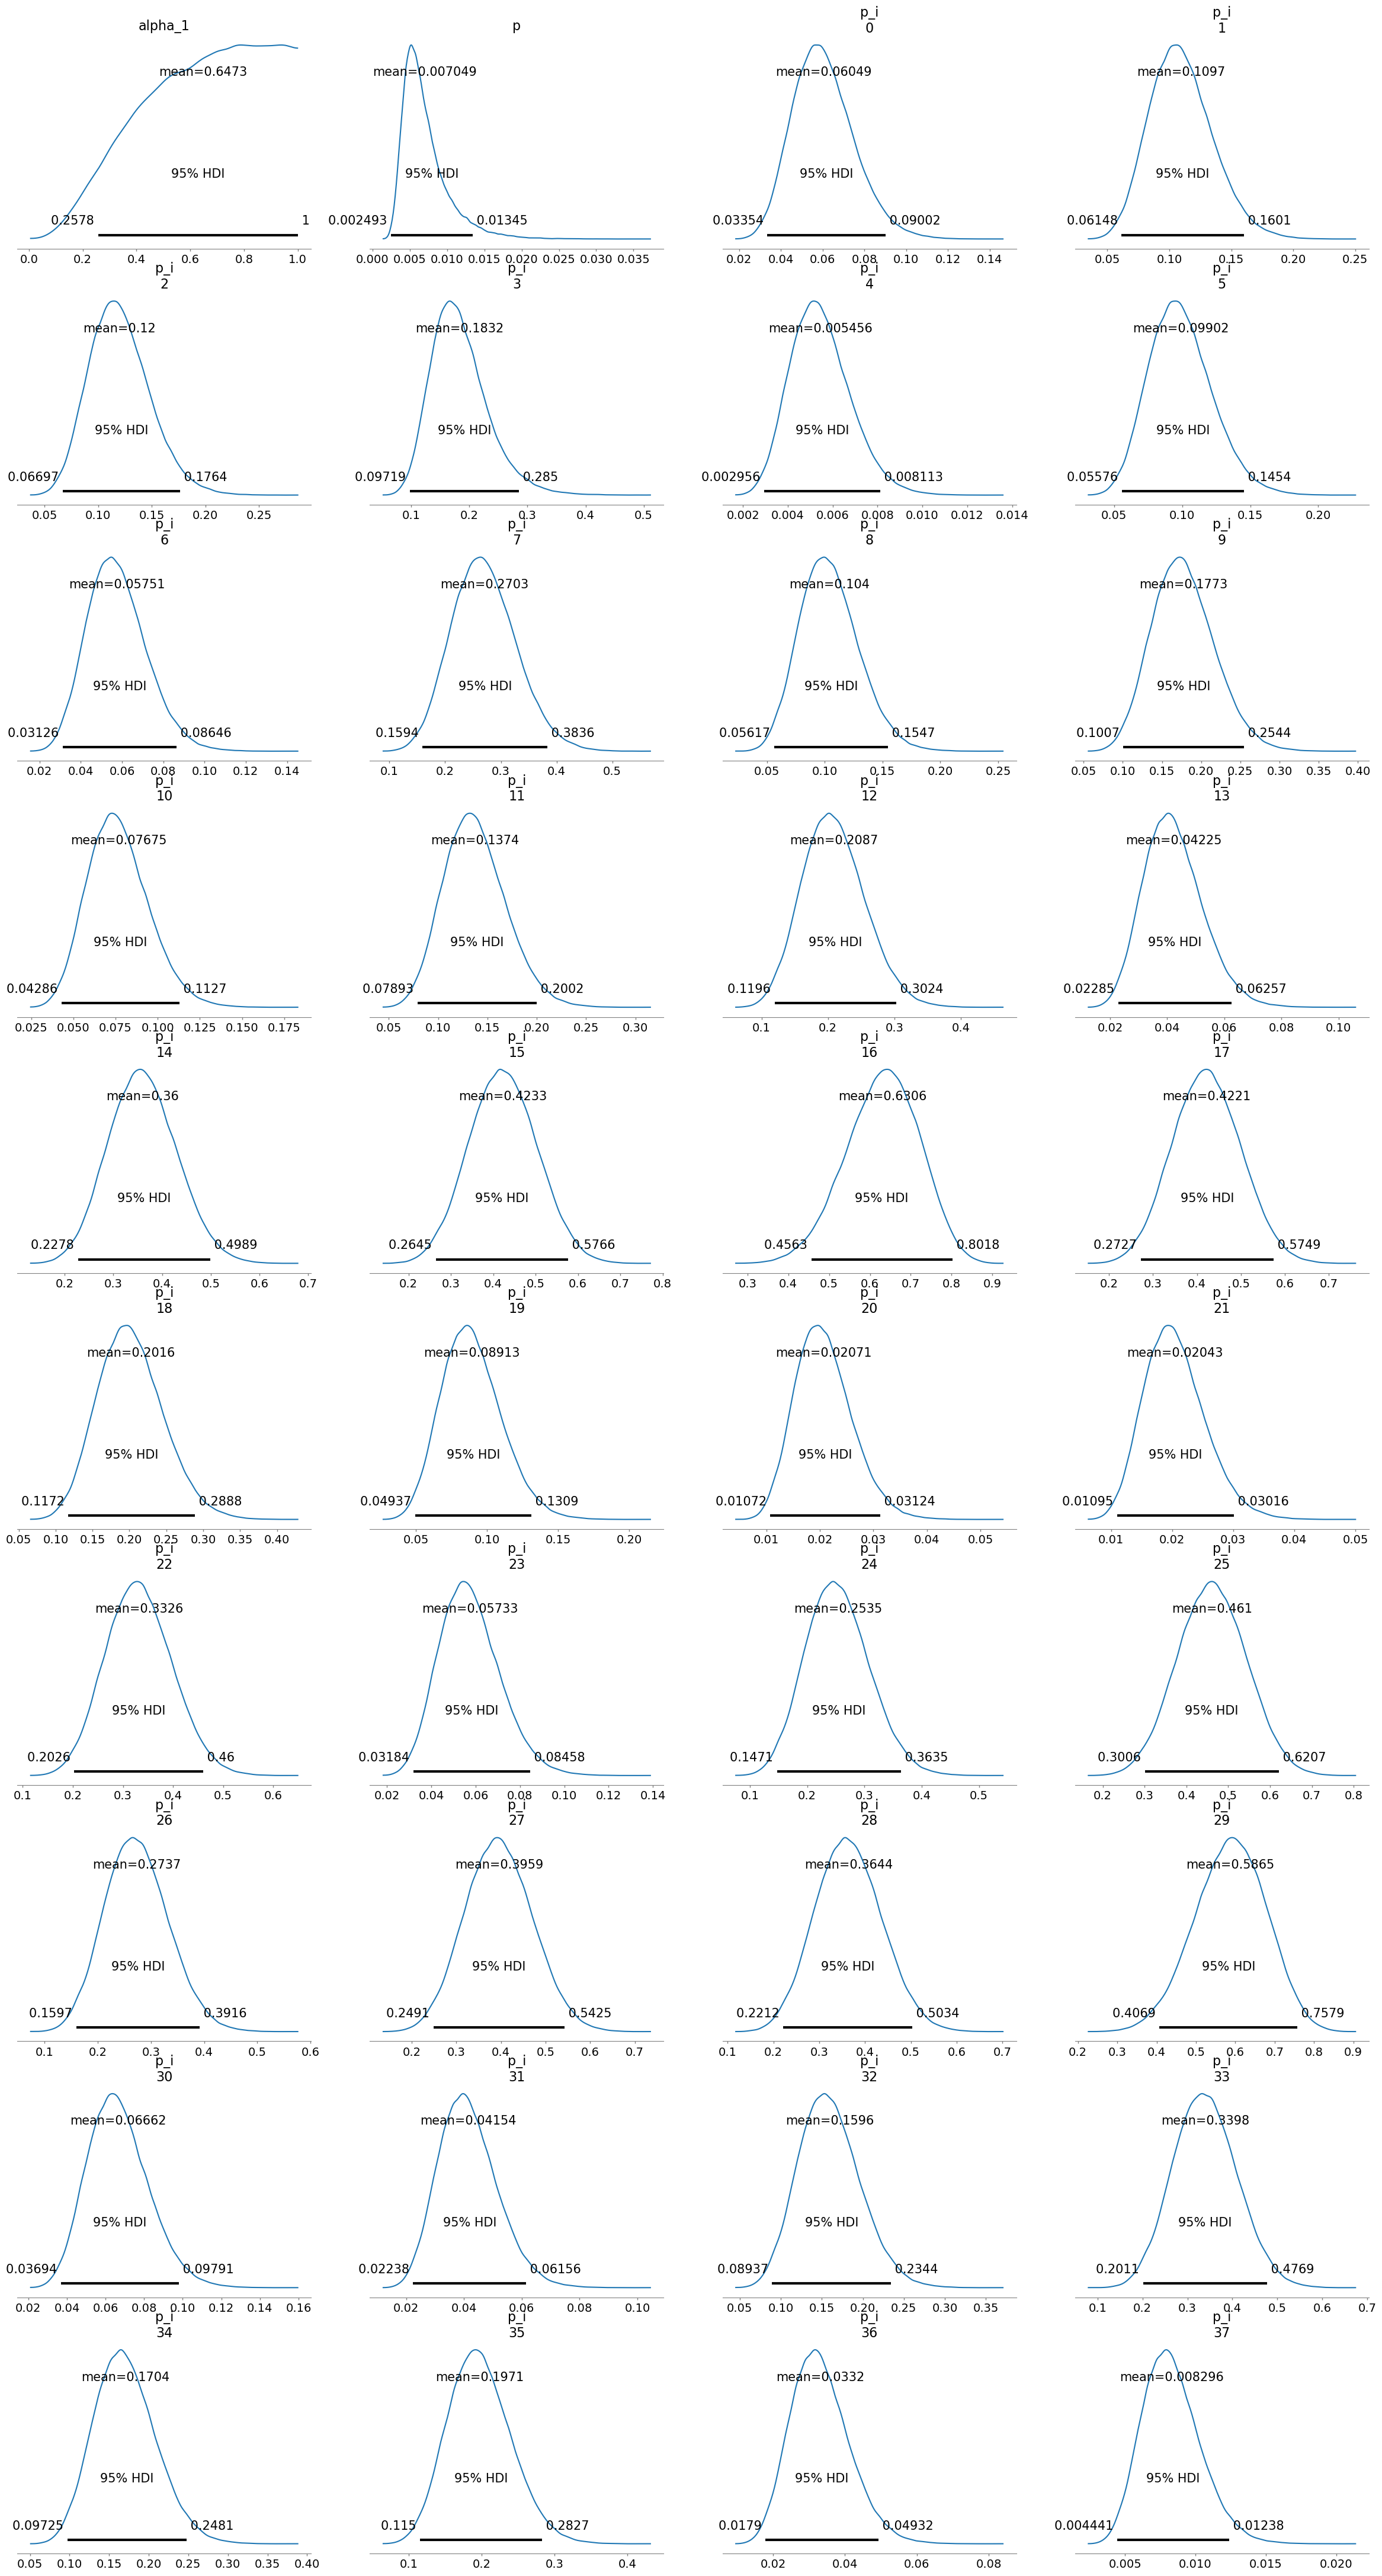

In [16]:
az.plot_posterior(trace2, round_to=4, hdi_prob=.95);

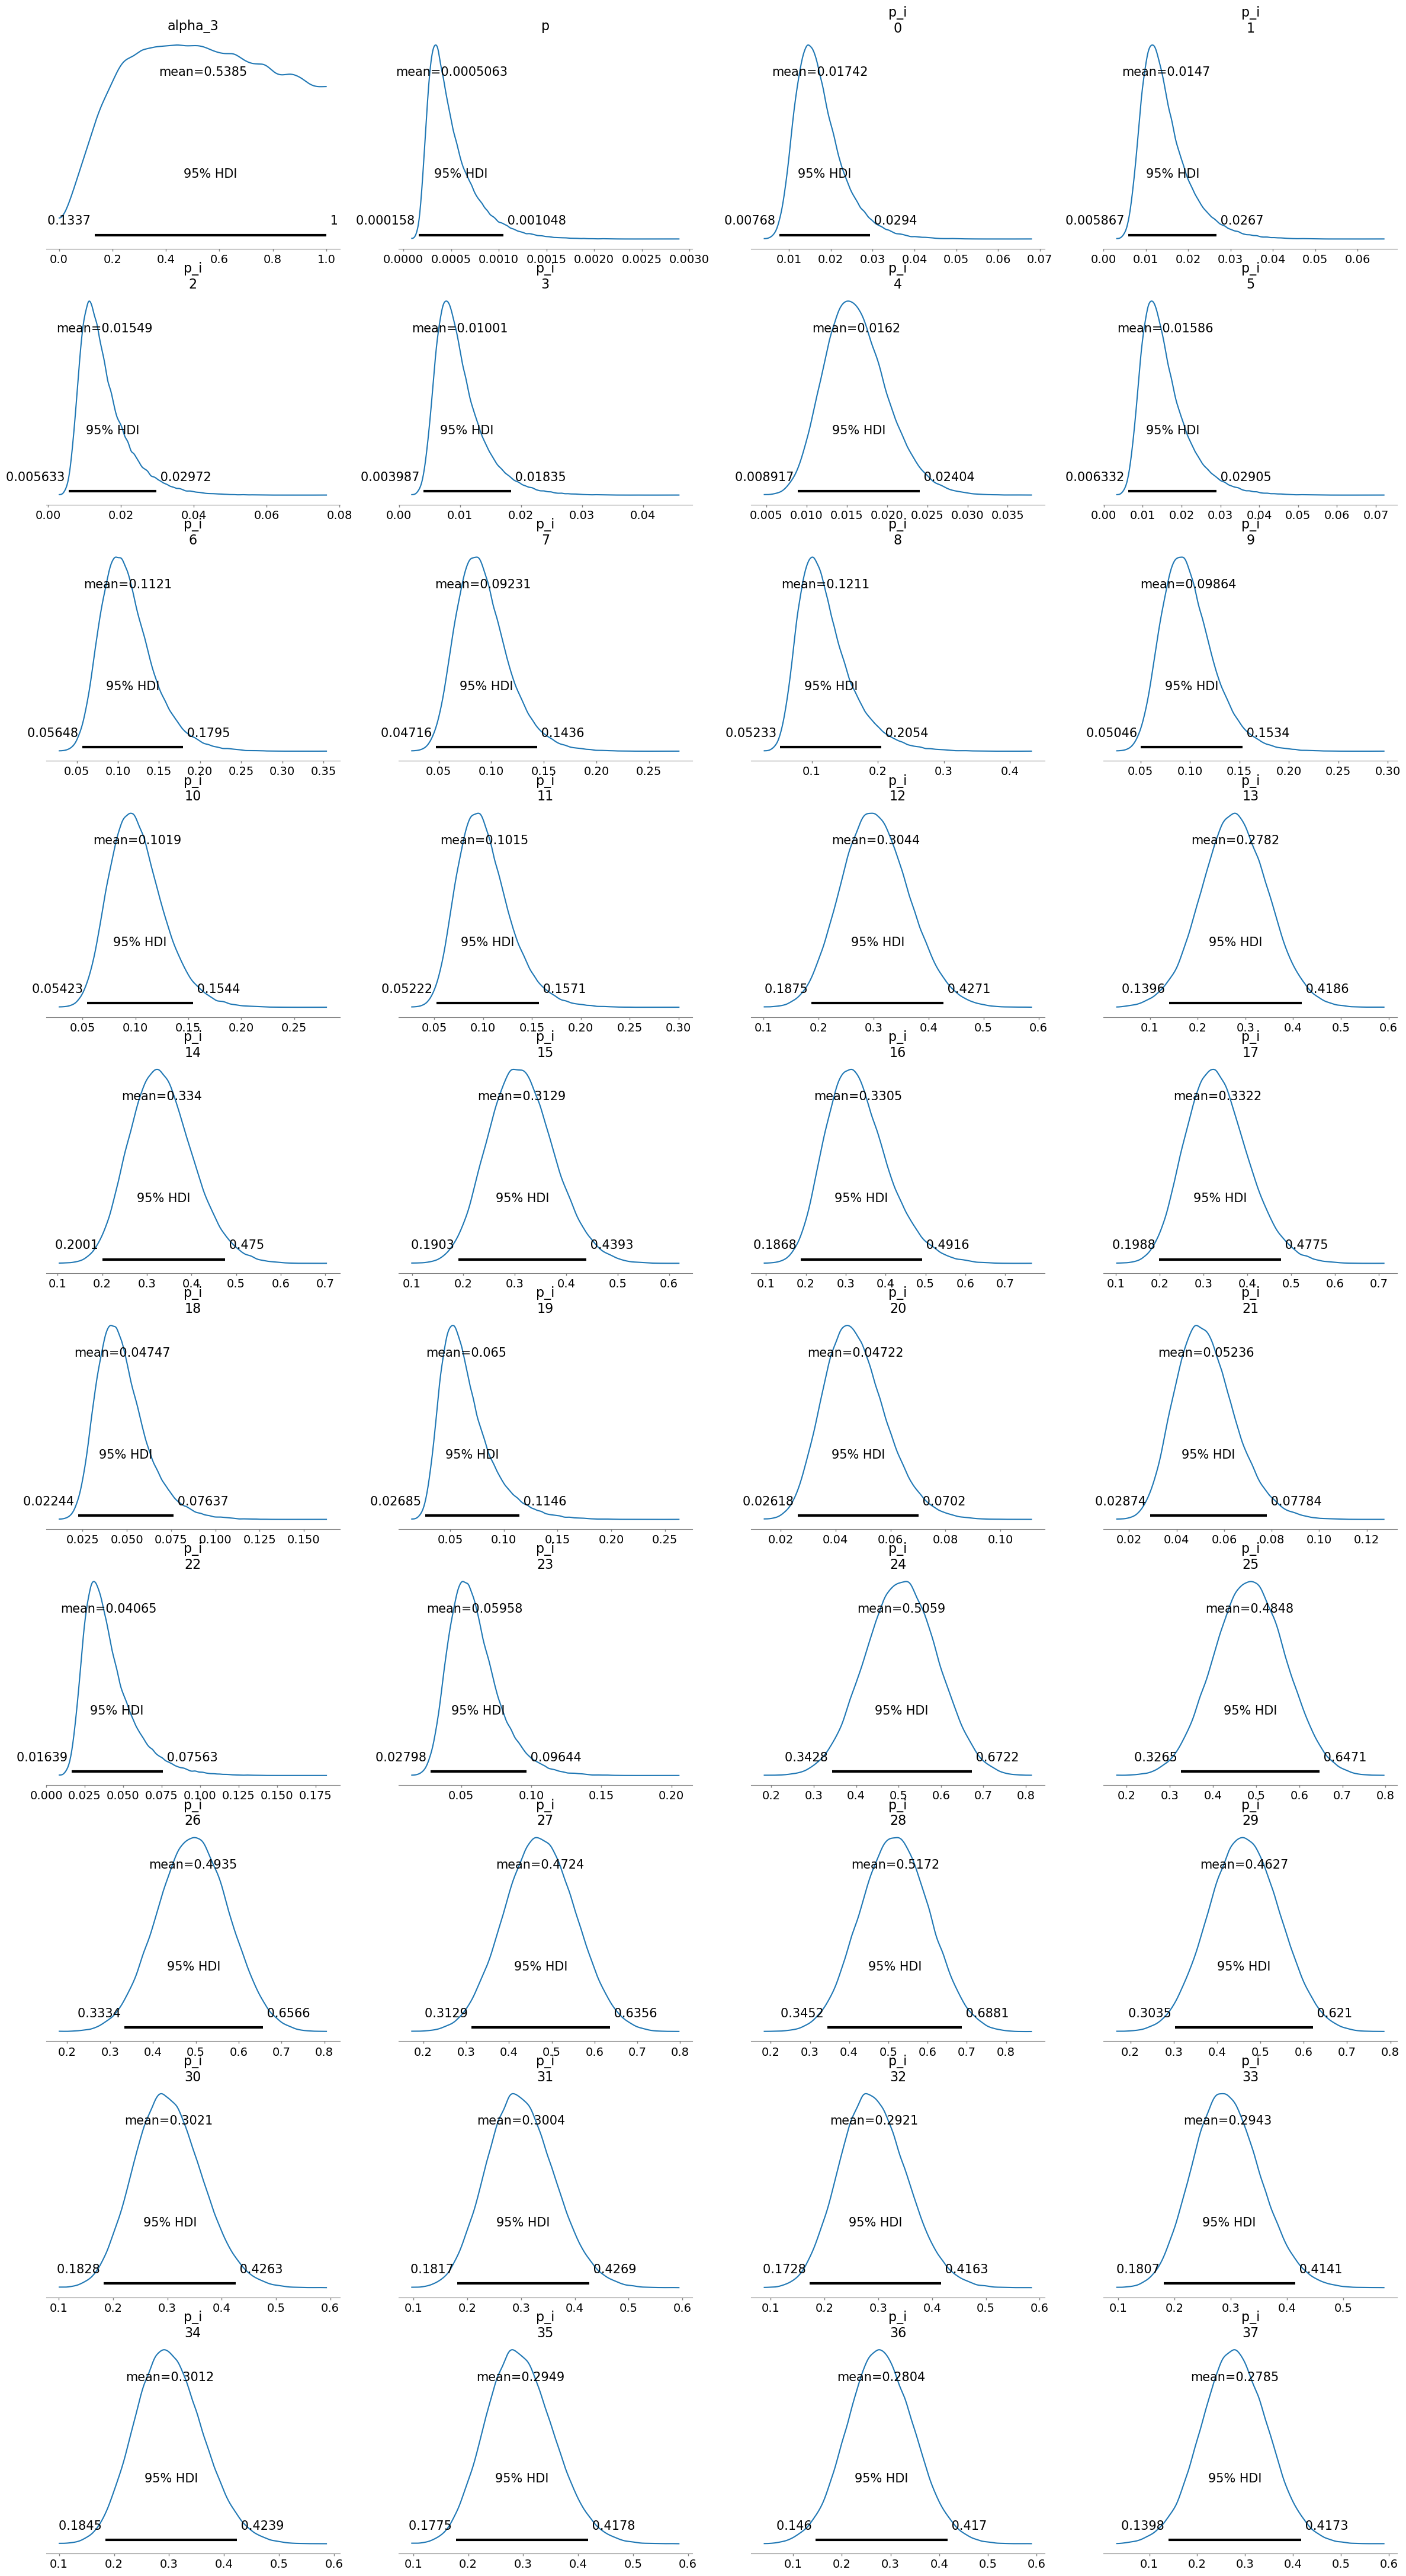

In [17]:
az.plot_posterior(trace3, round_to=4, hdi_prob=.95);

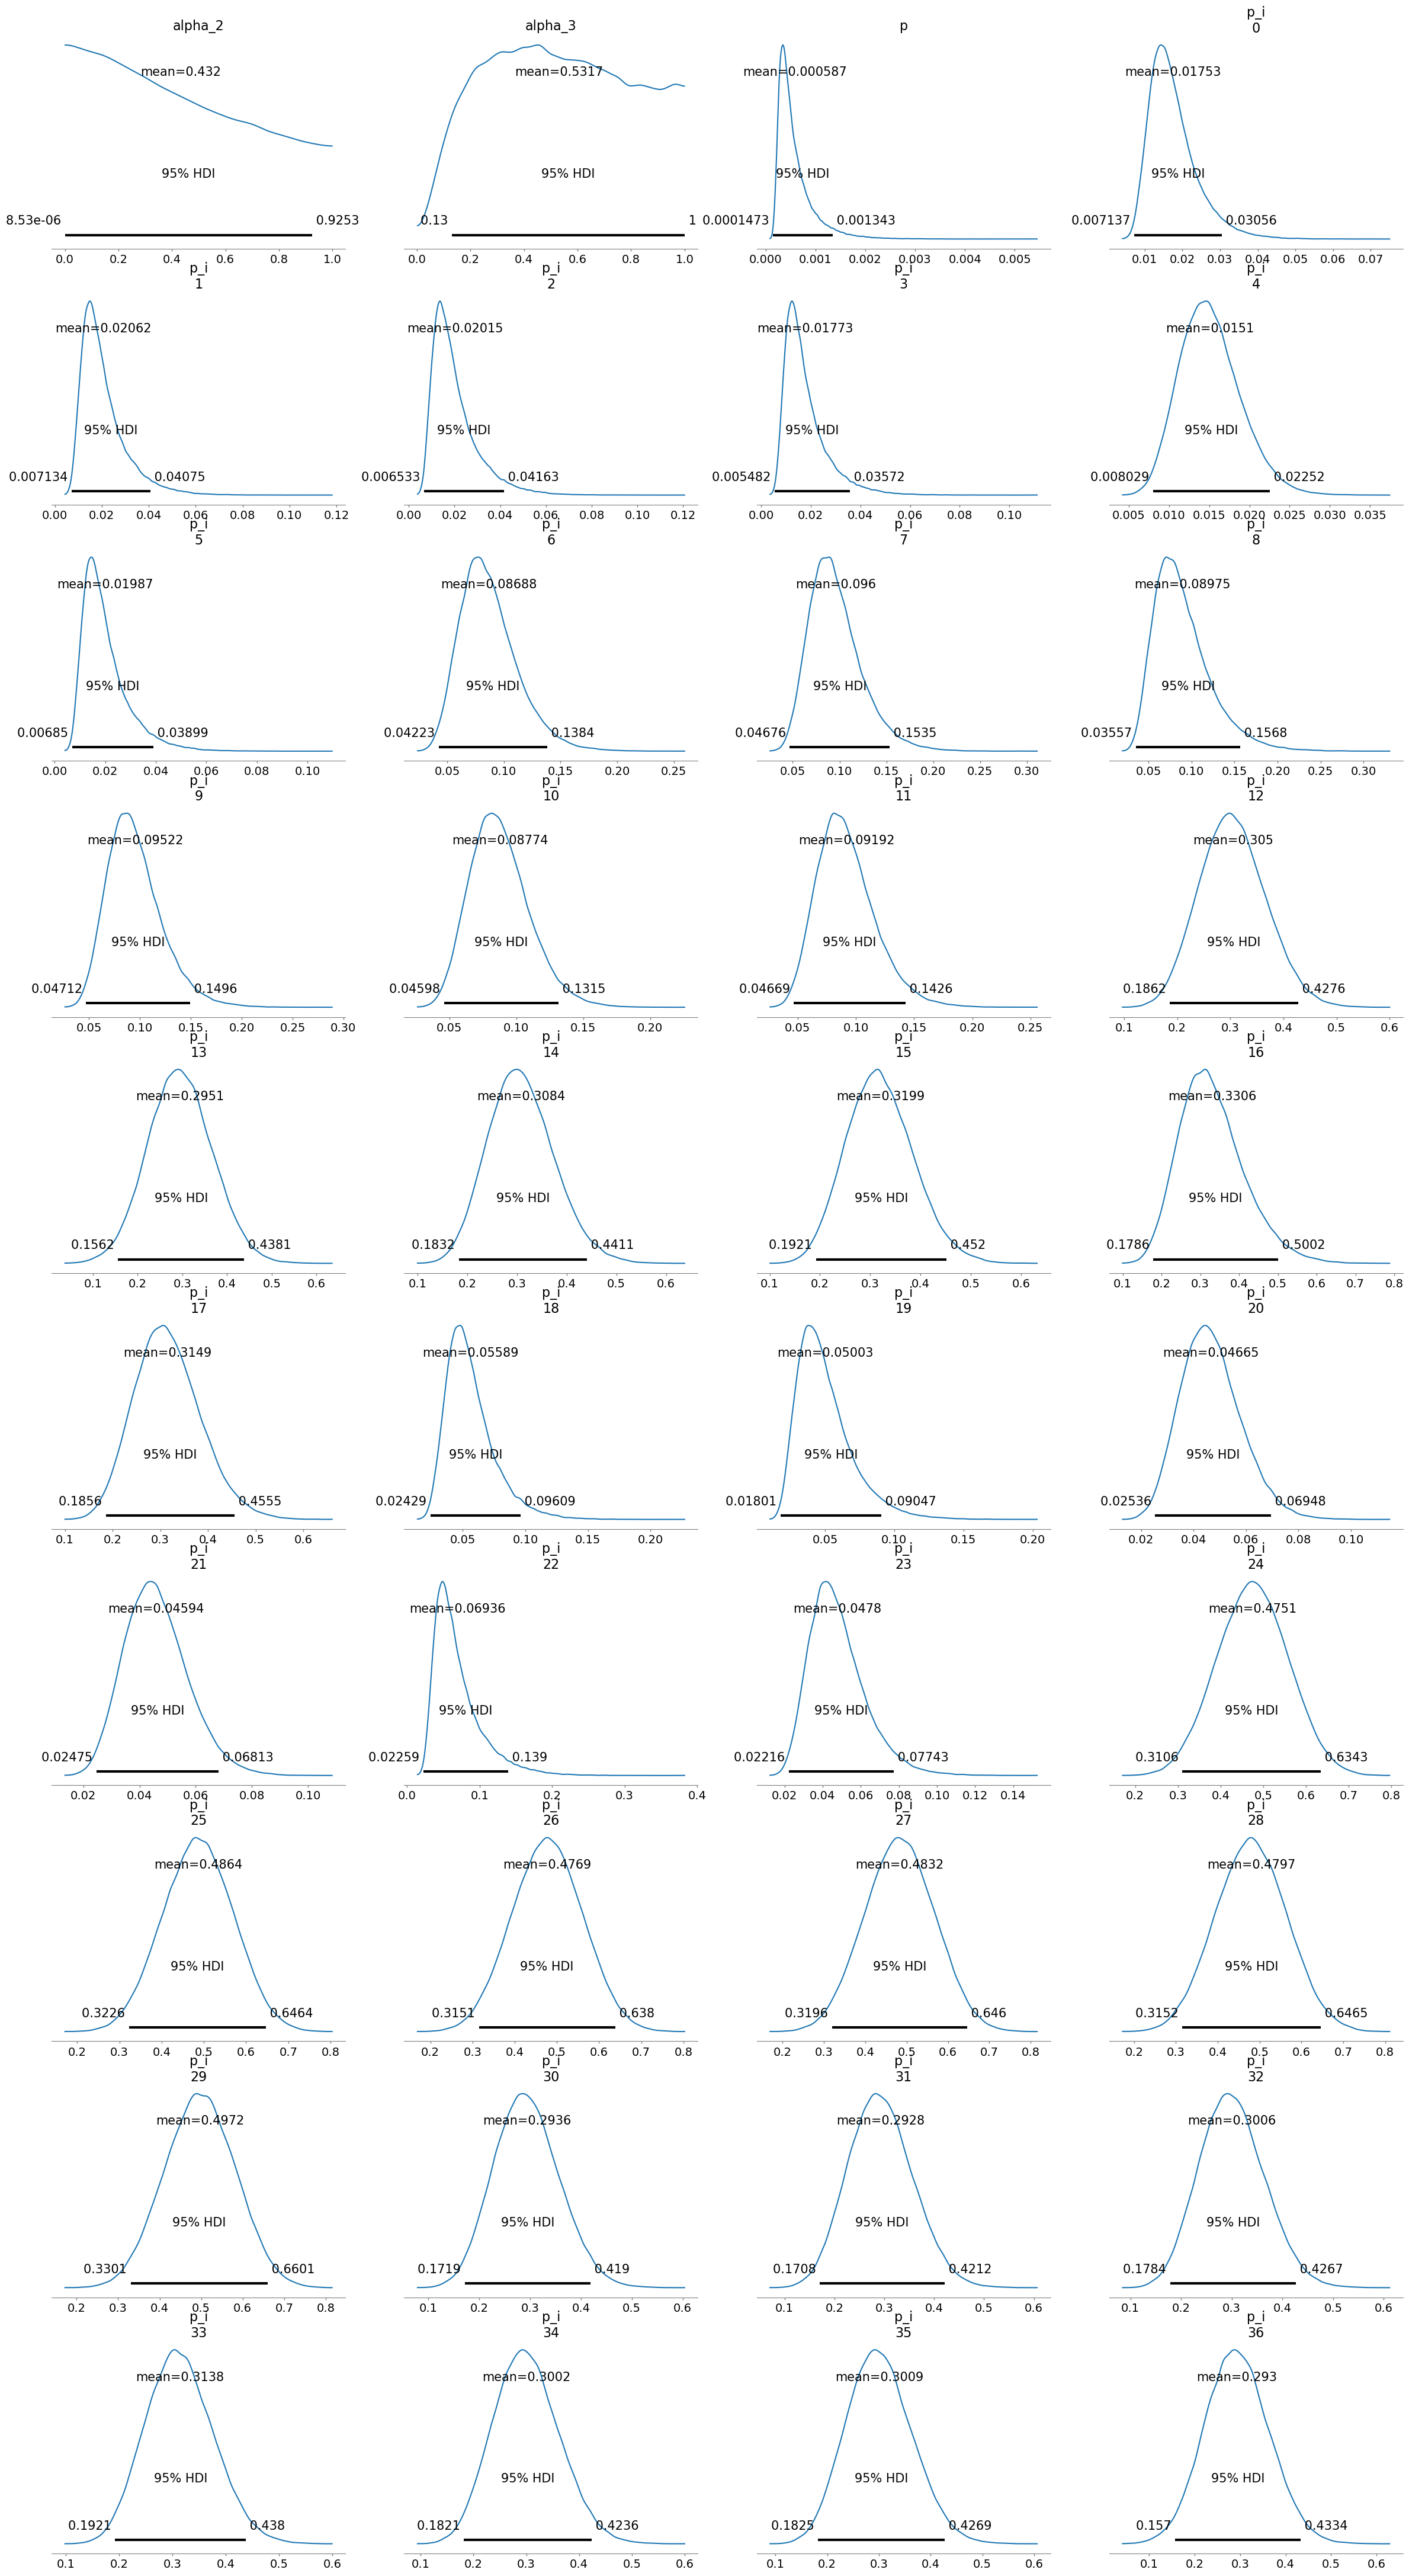

In [18]:
az.plot_posterior(trace4, round_to=4, hdi_prob=.95);

### ROC curves

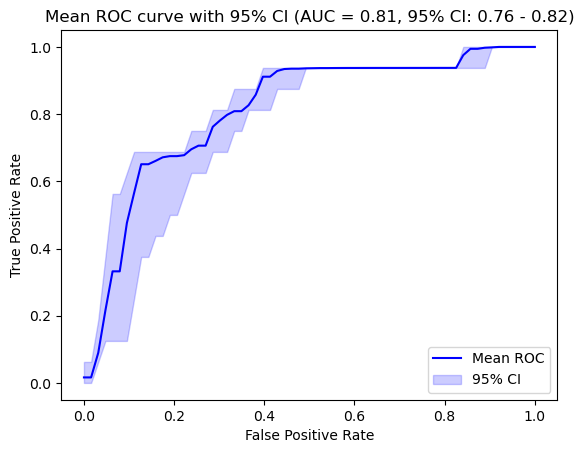

In [19]:
roc_model1 = plot_mean_roc(y, p_ind1)

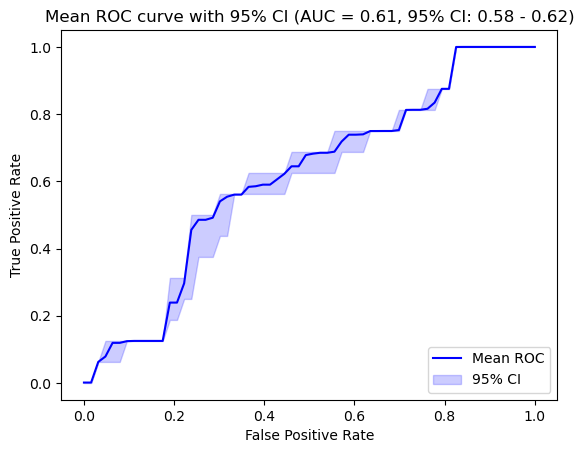

In [20]:
roc_model2 = plot_mean_roc(y, p_ind2)

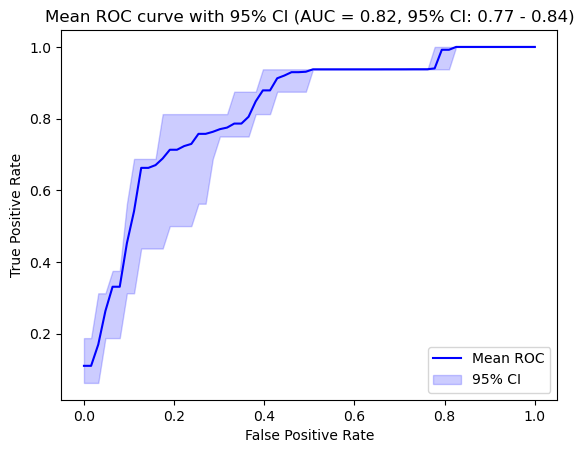

In [21]:
roc_model3 = plot_mean_roc(y, p_ind3)

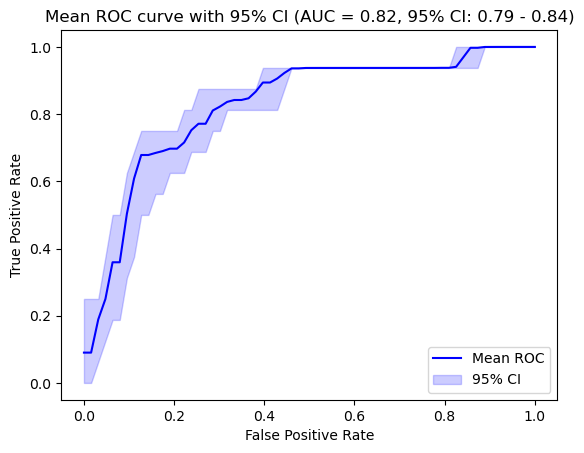

In [22]:
roc_model4 = plot_mean_roc(y, p_ind4)

### Confusion matrices

In [23]:
cm_model1 = calculate_mean_confusion_matrix(y, p_ind1, threshold=0.5)

Mean Confusion Matrix:
[[45.19595  2.80405]
 [11.95959  4.04041]]


In [ ]:
cm_model2 = calculate_mean_confusion_matrix(y, p_ind2, threshold=0.5)

In [ ]:
cm_model3 = calculate_mean_confusion_matrix(y, p_ind3, threshold=0.5)

In [ ]:
cm_model4 = calculate_mean_confusion_matrix(y, p_ind4, threshold=0.5)

## Model comparisons

### Model comparison: AIC & BIC 

In [25]:
results1 = calculate_information_criteria(trace1, model1, y)

print(f"AIC: {results1['AIC']}")
print(f"BIC: {results1['BIC']}")
print(f"WAIC: {results1['WAIC']}")

Output()

AIC: 12.929276641266501
BIC: 25.882575141424528
WAIC: Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -30.38     3.85
p_waic        1.23        -


In [42]:
# samples1 = trace1.posterior.stack(sample=("chain", "draw"))

# alpha1_samples1 = samples1['alpha_1'].values

# min(alpha1_samples1), max(alpha1_samples1)

In [43]:
results2 = calculate_information_criteria(trace2, model2, y)

print(f"AIC: {results2['AIC']}")
print(f"BIC: {results2['BIC']}")
print(f"WAIC: {results2['WAIC']}")

Output()

AIC: 5.284025117477011
BIC: 9.601791284196354
WAIC: Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -41.97     7.00
p_waic        1.66        -

There has been a warning during the calculation. Please check the results.


In [44]:
results3 = calculate_information_criteria(trace3, model3, y)

print(f"AIC: {results3['AIC']}")
print(f"BIC: {results3['BIC']}")
print(f"WAIC: {results3['WAIC']}")

Output()

AIC: 4.899977283254392
BIC: 9.217743449973735
WAIC: Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -29.35     3.65
p_waic        1.07        -


In [45]:
results4 = calculate_information_criteria(trace4, model4, y)

print(f"AIC: {results4['AIC']}")
print(f"BIC: {results4['BIC']}")
print(f"WAIC: {results4['WAIC']}")

Output()

AIC: 6.9018836780151345
BIC: 13.378532928094149
WAIC: Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -29.44     3.81
p_waic        1.12        -


### Model comparison: Widely Applicable Information Criterion (WAIC)

In [46]:
log_likelihood = trace2.log_likelihood
print(log_likelihood)

<xarray.Dataset> Size: 51MB
Dimensions:      (chain: 10, draw: 10000, y_obs_dim_0: 64)
Coordinates:
  * chain        (chain) int64 80B 0 1 2 3 4 5 6 7 8 9
  * draw         (draw) int64 80kB 0 1 2 3 4 5 ... 9994 9995 9996 9997 9998 9999
  * y_obs_dim_0  (y_obs_dim_0) int64 512B 0 1 2 3 4 5 6 ... 57 58 59 60 61 62 63
Data variables:
    y_obs        (chain, draw, y_obs_dim_0) float64 51MB -0.05915 ... -0.2471
Attributes:
    created_at:                 2024-08-20T11:12:02.934772+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2


In [52]:
log_likelihood_data = trace2['log_likelihood']
print(np.isnan(log_likelihood_data).sum(), "\n\n")
print(np.isinf(log_likelihood_data).sum())

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    y_obs    int64 8B 0 


<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    y_obs    int64 8B 0


In [53]:
inf_indices = np.isinf(log_likelihood_data['y_obs']).values
print("Indices des valeurs infinies :", np.where(inf_indices)[0])

Indices des valeurs infinies : []


In [59]:
waic1 = pm.waic(trace1, model1)
waic1

Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -30.38     3.85
p_waic        1.23        -

In [57]:
waic2 = pm.waic(trace2, model2)
waic2

Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -41.97     7.00
p_waic        1.66        -

There has been a warning during the calculation. Please check the results.

In [56]:
waic3 = pm.waic(trace3, model3)
waic3

Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -29.35     3.65
p_waic        1.07        -

In [58]:
waic4 = pm.waic(trace4, model4)
waic4

Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -29.44     3.81
p_waic        1.12        -

### Model comparison: Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV)

In [60]:
models = {
    "model1": trace1,
    "model2": trace2,
    "model3": trace3,
    "model4": trace4,
}
model_compare_default = az.compare(models)
model_compare_default

rank   elpd_loo     p_loo  elpd_diff        weight        se  \
model3     0 -29.349297  1.068863   0.000000  1.000000e+00  3.650740   
model4     1 -29.438902  1.119870   0.089606  0.000000e+00  3.814181   
model1     2 -30.385894  1.237032   1.036597  9.589074e-16  3.856095   
model2     3 -41.983638  1.679682  12.634342  0.000000e+00  7.004376   

             dse  warning scale  
model3  0.000000    False   log  
model4  0.424880    False   log  
model1  0.809409    False   log  
model2  5.273779    False   log

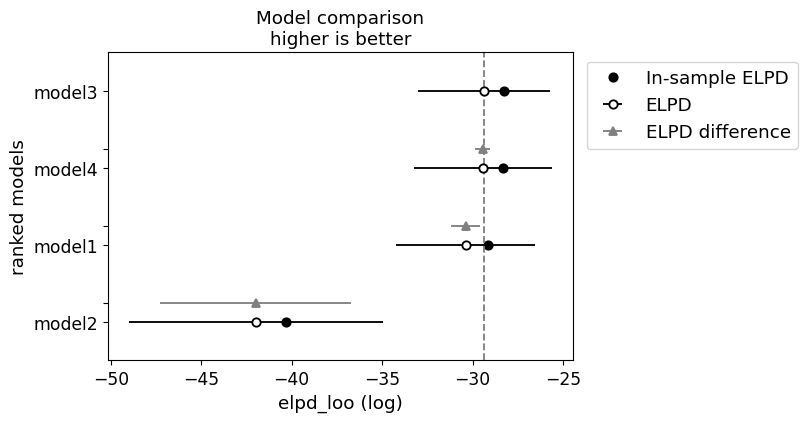

In [61]:
az.plot_compare(model_compare_default, insample_dev=True);

In [62]:
model_compare_waic = az.compare(models, ic='waic', method='BB-pseudo-BMA', b_samples=1000)
model_compare_waic

rank  elpd_waic    p_waic  elpd_diff    weight        se       dse  \
model3     0 -29.347542  1.067109   0.000000  0.439508  3.633007  0.000000   
model4     1 -29.436337  1.117305   0.088795  0.389616  3.811971  0.424498   
model1     2 -30.377992  1.229130   1.030450  0.169968  3.888846  0.805157   
model2     3 -41.968552  1.664595  12.621010  0.000908  7.266504  5.267563   

        warning scale  
model3    False   log  
model4    False   log  
model1    False   log  
model2     True   log

In [63]:
model_compare_loo = az.compare(models, ic='loo', method='BB-pseudo-BMA', b_samples=1000)
model_compare_loo

rank   elpd_loo     p_loo  elpd_diff    weight        se       dse  \
model3     0 -29.349297  1.068863   0.000000  0.433766  3.565183  0.000000   
model4     1 -29.438902  1.119870   0.089606  0.391358  3.696086  0.424880   
model1     2 -30.385894  1.237032   1.036597  0.172361  3.750375  0.809409   
model2     3 -41.983638  1.679682  12.634342  0.002515  6.987940  5.273779   

        warning scale  
model3    False   log  
model4    False   log  
model1    False   log  
model2    False   log

### Classification report: F1 score

In [ ]:
f1_model1 = calculate_mean_f1(y, p_ind1, threshold=0.5)

In [ ]:
f1_model2 = calculate_mean_f1(y, p_ind2, threshold=0.5)

In [ ]:
f1_model3 = calculate_mean_f1(y, p_ind3, threshold=0.5)

In [ ]:
f1_model4 = calculate_mean_f1(y, p_ind4, threshold=0.5)

### Saving models' traces

In [65]:
with open('trace_model1.pkl', 'wb') as f:
    pickle.dump(trace1, f)

with open('trace_model2.pkl', 'wb') as f:
    pickle.dump(trace2, f)

with open('trace_model3.pkl', 'wb') as f:
    pickle.dump(trace3, f)

with open('trace_model4.pkl', 'wb') as f:
    pickle.dump(trace4, f)